<div>
    <h1>Group 1, Milestone 4</h1>
    <h2>AC209a, Fall 2024</h2>
</div>

**Note**: 
- CSS styles are applied by the **last cell** in the notebook. Please run that cell if the notebook appears non-styled.
- This notebook requires the **openpyxl** package to run.



# Table of Contents: #

- [Introduction](#Introduction)
  - [Finalized Research Question](#Finalized-Research-Question)
  - [About the Data Set](#About-the-Data-Set)
  - [Brief Data Summary](#Brief-Data-Summary)
  - [Exploratory Data Analysis](#Exploratory-Data-Analysis)
  - [Observed Patterns and Trends](#Observed-Patterns-and-Trends)
  - [Overall Data Summary](#Overall-Data-Summary)
- [Feature Transformations](#Feature-Transformations)
  - [Missingness](#Missingness)
  - [Data Preprocessing](#Data-Preprocessing)
  - [Feature Transformation](#Feature-Transformation)
- [Bag of Words Implementation](#Bag-of-Words-Implementation)
- [Pipeline](#Pipeline)
- [Model](#Model)
- [Results and Analysis](#Results-and-Analysis)

# Introduction

## Finalized Research Question
<p>What characteristics of an environmental protection project are the most important in
determining how much money it receives from multilateral climate funds, and how well can the
total amount of money raised for these projects be predicted?</p>

## About the Data Set
<a id="about-the-data-set"></a>
<p>We have sourced a dataset from <a href="https://climatefundsupdate.org">Climate Funds Update</a>, an
independent website supported financially by the Heinrich-Böll-Stiftung foundation in
Washington, DC, and ODI, a think tank. The Climate Funds Update tracks the amount of money
pledged and deployed by multilateral climate funds to assist developing nations in adapting
"climate-resilient development trajectories.</p>

## Brief Data Summary
<a id="brief-data-summary"></a>
<p>We are principally concerned with the data published by the Climate Funds Update related to
funded projects. This data set is presented in an Excel file that has mostly already been curated.
The dataset contains 3,428 observations of funded projects, with 26 columns/variables.
The data set includes both numerical and categorical columns. The variables that we are
particularly interested in to answer our research questions are:</p>

<li class="m4"><strong>Predictors:</strong> variables related to the nature and geographic location of each project. Important
predictors are Funding Type, Country, World Bank Region, Income Classification, Theme,
Sector, Approved Year. All predictors are categorical except Approved Year (numerical).</li>

<li class="m4"><strong>Response:</strong> the total amount of funding for each project, which is numerical, in millions of USD.
In this EDA report, we will mainly focus on the above variables of interest. Several other
variables in the data set are not directly related to our research questions. Their data types and
characteristics are summarized later in this ipynb.</li>

## Exploratory Data Analysis

<p>The header of the data is presented below:</p>

In [1]:
import pandas as pd
import re
from collections import Counter
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

projects_df = pd.read_excel('CFU-Website-MASTER-February-2024.xlsx', sheet_name='Projects' )

columns_to_rename = {
    'Theme/Objective': 'Theme',
    'Sector (OECD)': 'Sector',
    'Amount of Funding Approved (USD millions)': 'Total Funding',
    ' Disbursed (USD millions)': 'Disbursed'
}

projects_df.rename(columns=columns_to_rename, inplace=True)

projects_df.head()

,Fund,Fund Type,Country,World Bank Region,Income Classification,Name of Project,Theme,Sector,DAC 5 Code,Sub-Sector,...,End year,Concessional loan,Grant,Guarantee,Equity,Total Funding,Disbursed,Least Developed Country,Small Island Developing Nation,Fragile or Conflict Affected State
0,Green Climate Fund (GCF-1),Multilateral,Sri Lanka,South Asia,Lower middle income,(FP124) Strengthening Climate Resilience of Su...,Adaptation,Water Supply & Sanitation,DAC140_,Water sector policy and administrative management,...,2026,NaN,39.78,NaN,NaN,39.78,4.18,NaN,NaN,NaN
1,Global Environment Facility (GEF7),Multilateral,India,South Asia,Lower middle income,Accelerating adoption of super-efficient techn...,Multiple Foci,Energy,DAC230_,NaN,...,NaN,NaN,4.42,NaN,NaN,4.42,NaN,NaN,NaN,NaN
2,Global Environment Facility (GEF4),Multilateral,India,South Asia,Lower middle income,Achieving Reduction in GHG Emissions through A...,Mitigation - General,Energy,DAC230_,"Energy generation, distribution and efficiency...",...,NaN,NaN,0.25,NaN,NaN,0.25,0.25,NaN,NaN,NaN
3,Least Developed Countries Fund (LDCF),Multilateral,Afghanistan,South Asia,Low income,Adapting Afghan Communities to Climate-Induced...,Adaptation,Disaster Prevention & Preparedness,DAC740_,Disaster prevention and preparedness,...,NaN,NaN,5.60,NaN,NaN,5.60,NaN,LDC,NaN,FCAS
4,Least Developed Countries Fund (LDCF),Multilateral,Bhutan,South Asia,Lower middle income,Enhancing the Climate Resilience of Urban Land...,Adaptation,Disaster Prevention & Preparedness,DAC740_,Multi-hazard response preparedness,...,NaN,NaN,18.05,NaN,NaN,18.05,NaN,LDC,NaN,NaN


<p>In this part, we examine basic information of the raw data, including shape, data types, and descriptive statistics.</p>

<p>We notice that some entries of the data set are "Not applicable", we are going to replace them with NaN to ensure the count of missing data is correct.</p>

<p>We also convert numerical columns to float data type, and we only present descriptive statistics for these columns.</p>

In [2]:
projects_df.replace('Not applicable', float('nan'), inplace=True)
numerical_cols= ['Approved year', 'End year', 'Concessional loan', 'Grant', 'Guarantee', 'Equity', 'Total Funding', 'Disbursed']
for col in numerical_cols:
    projects_df[col] = pd.to_numeric(projects_df[col], errors='coerce')

projects_df[['Approved year', 'End year']] = projects_df[['Approved year', 'End year']].astype('Int64')

In [3]:
projects_summary = {
    "Shape": projects_df.shape,
    "Data Types": projects_df.dtypes,
    "Missing Values": projects_df.isnull().sum(),
    "Summary Statistics": projects_df[numerical_cols].describe(include='all')
}

In [4]:
print('Shape of the data set:', projects_summary["Shape"])

Shape of the data set: (3428, 26)


In [5]:
print('Data Types of all columns:')
print( projects_summary["Data Types"] )

Data Types of all columns:
Fund                                   object
Fund Type                              object
Country                                object
World Bank Region                      object
Income Classification                  object
Name of Project                        object
Theme                                  object
Sector                                 object
DAC 5 Code                             object
Sub-Sector                             object
Key words                              object
Summary                                object
Implementing Agency                    object
Recipient Institution                  object
Recipient Institution type             object
Approved year                           Int64
End year                                Int64
Concessional loan                     float64
Grant                                 float64
Guarantee                             float64
Equity                                float64
Total F

In [6]:
print('Number of missing values in each column:')
print(projects_summary["Missing Values"])

Number of missing values in each column:
Fund                                     0
Fund Type                                0
Country                                  0
World Bank Region                      193
Income Classification                  468
Name of Project                          0
Theme                                    0
Sector                                   0
DAC 5 Code                               0
Sub-Sector                             211
Key words                             1898
Summary                               1779
Implementing Agency                     58
Recipient Institution                 1457
Recipient Institution type            3004
Approved year                           45
End year                              2140
Concessional loan                     3149
Grant                                   88
Guarantee                             3415
Equity                                3407
Total Funding                            0
Disbursed    

In [7]:
print('Descriptive Statistics of data columns')
print(projects_summary["Summary Statistics"])

Descriptive Statistics of data columns
       Approved year    End year  Concessional loan        Grant   Guarantee  \
count         3383.0      1288.0         279.000000  3340.000000   13.000000   
mean     2016.241502  2020.46972          40.412401     6.068698   28.659231   
std         4.499021    4.567955          54.187711    13.538716   33.533696   
min           2003.0      2005.0           0.100000     0.000000    1.500000   
25%           2013.0      2017.0           9.300000     0.640000    9.000000   
50%           2017.0      2021.0          20.000000     2.455000   13.000000   
75%           2020.0      2023.0          49.235000     6.340000   30.000000   
max           2023.0      2042.0         344.000000   307.390000  100.000000   

           Equity  Total Funding    Disbursed  
count   21.000000    3428.000000  2457.000000  
mean    74.502576       9.764399     5.520662  
std     67.727454      25.935438    14.805122  
min      4.654103       0.000000     0.000000  


As highlighted in Milestone 3, there is a problem with the Theme feature having both 'Multiple Foci' and 'Multiple foci' as classes. These classes should be merged together as they represent the same thing.

In [8]:
projects_df['Theme'] = projects_df['Theme'].replace({'Multiple foci': 'Multiple Foci'})

1. <p>We create 4 bar plots to show the distribution of different fund types, world bank regions, income classification, and theme:</p>

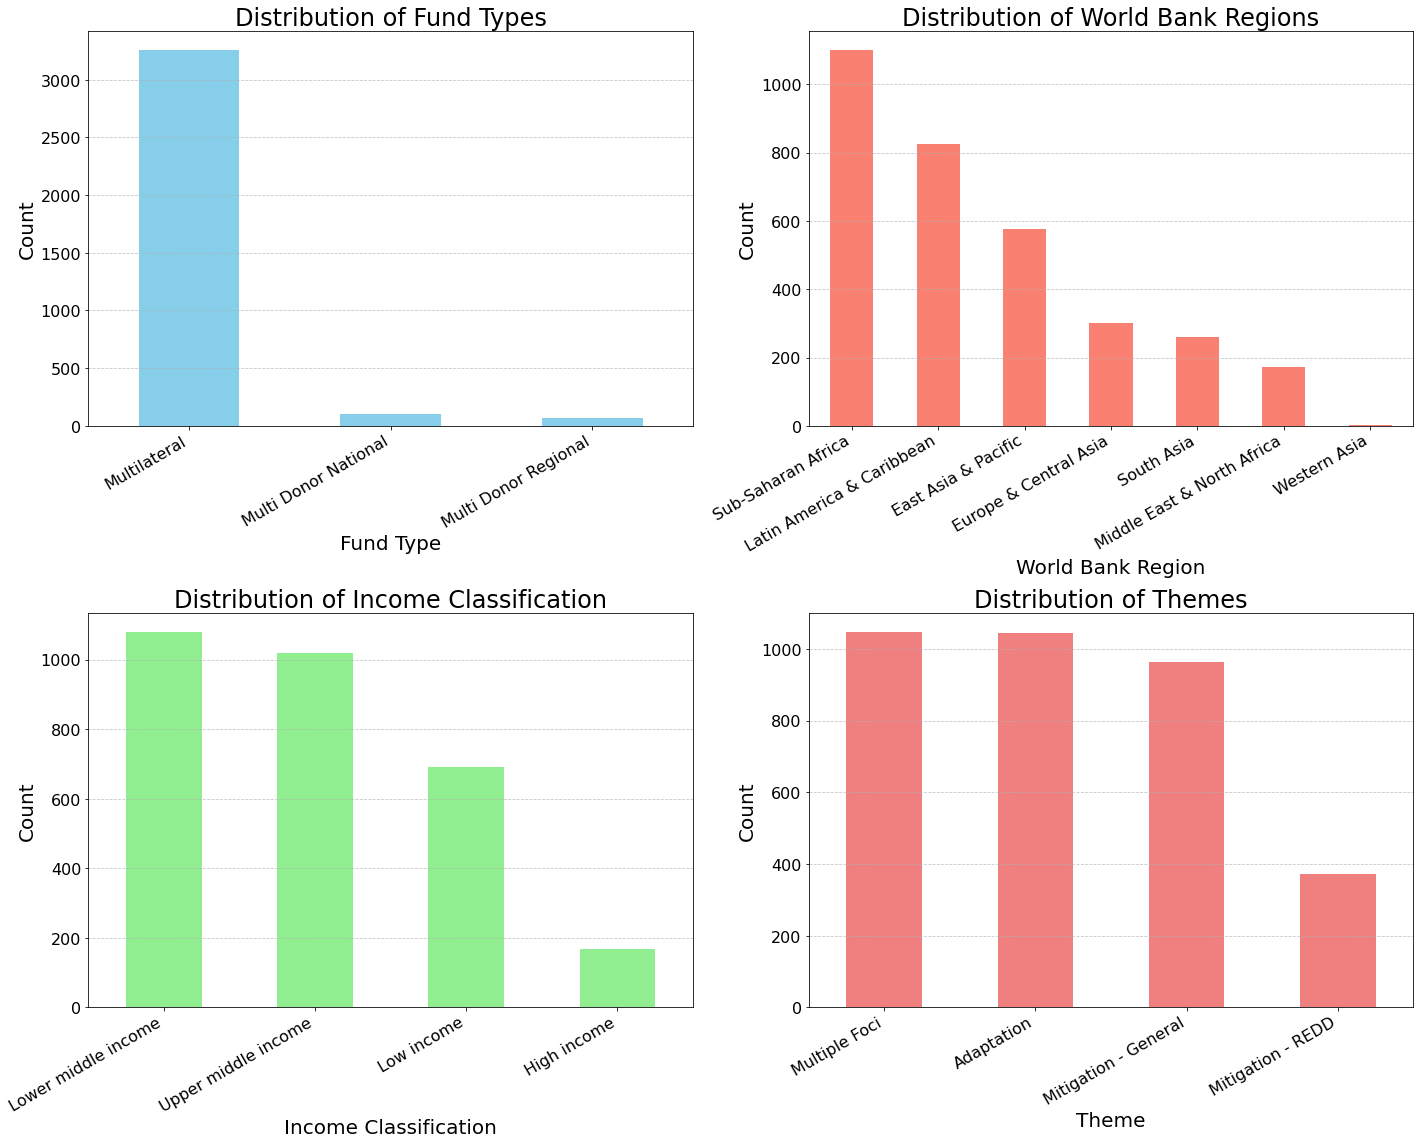

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Plot 1: Distribution of Fund Types
projects_df['Fund Type'].value_counts().plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Distribution of Fund Types', fontsize=24)
axes[0, 0].set_xlabel('Fund Type', fontsize=20)
axes[0, 0].set_ylabel('Count', fontsize=20)
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=30, ha='right')
axes[0, 0].tick_params(axis='both', which='major', labelsize=16)

# Plot 2: Distribution of World Bank Regions
projects_df['World Bank Region'].value_counts().plot(kind='bar', ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('Distribution of World Bank Regions', fontsize=24)
axes[0, 1].set_xlabel('World Bank Region', fontsize=20)
axes[0, 1].set_ylabel('Count', fontsize=20)
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=30, ha='right')
axes[0, 1].tick_params(axis='both', which='major', labelsize=16)


# Plot 3: Distribution of Income Classification
projects_df['Income Classification'].value_counts().plot(kind='bar', ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Distribution of Income Classification', fontsize=24)
axes[1, 0].set_xlabel('Income Classification', fontsize=20)
axes[1, 0].set_ylabel('Count', fontsize=20)
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=30, ha='right')
axes[1, 0].tick_params(axis='both', which='major', labelsize=16)

# Plot 4: Distribution of Themes
projects_df['Theme'].value_counts().plot(kind='bar', ax=axes[1, 1], color='lightcoral')
axes[1, 1].set_title('Distribution of Themes', fontsize=24)
axes[1, 1].set_xlabel('Theme', fontsize=20)
axes[1, 1].set_ylabel('Count', fontsize=20)
axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=30, ha='right')
axes[1, 1].tick_params(axis='both', which='major', labelsize=16)


plt.tight_layout()
plt.show()

**Analysis:**

1. **Fund Types**: Most projects are funded through "Multilateral" funds, while "Multi Donor National" and "Multi Donor Regional" funding types are rare.

2. **World Bank Regions**: The majority of projects are in "Sub-Saharan Africa," followed by "Latin America & Caribbean" and "East Asia & Pacific," highlighting a focus on regions with developing economies.

3. **Income Classification**: Projects are primarily targeted at "Lower middle income" and "Upper middle income" countries, with limited funding for "High income" nations, indicating a focus on less wealthy countries.

4. **Themes**: Projects are well-distributed across "Multiple Foci," "Adaptation," and "Mitigation - General." However, "Mitigation - REDD" has far fewer projects.

Overall, funding targets multilateral channels, developing regions, lower-income countries, and broad climate themes focused on adaptation and general mitigation.

2. <p>We create 4 box plots for funding amounts by funding type, world bank region, income classification, and theme.</p>

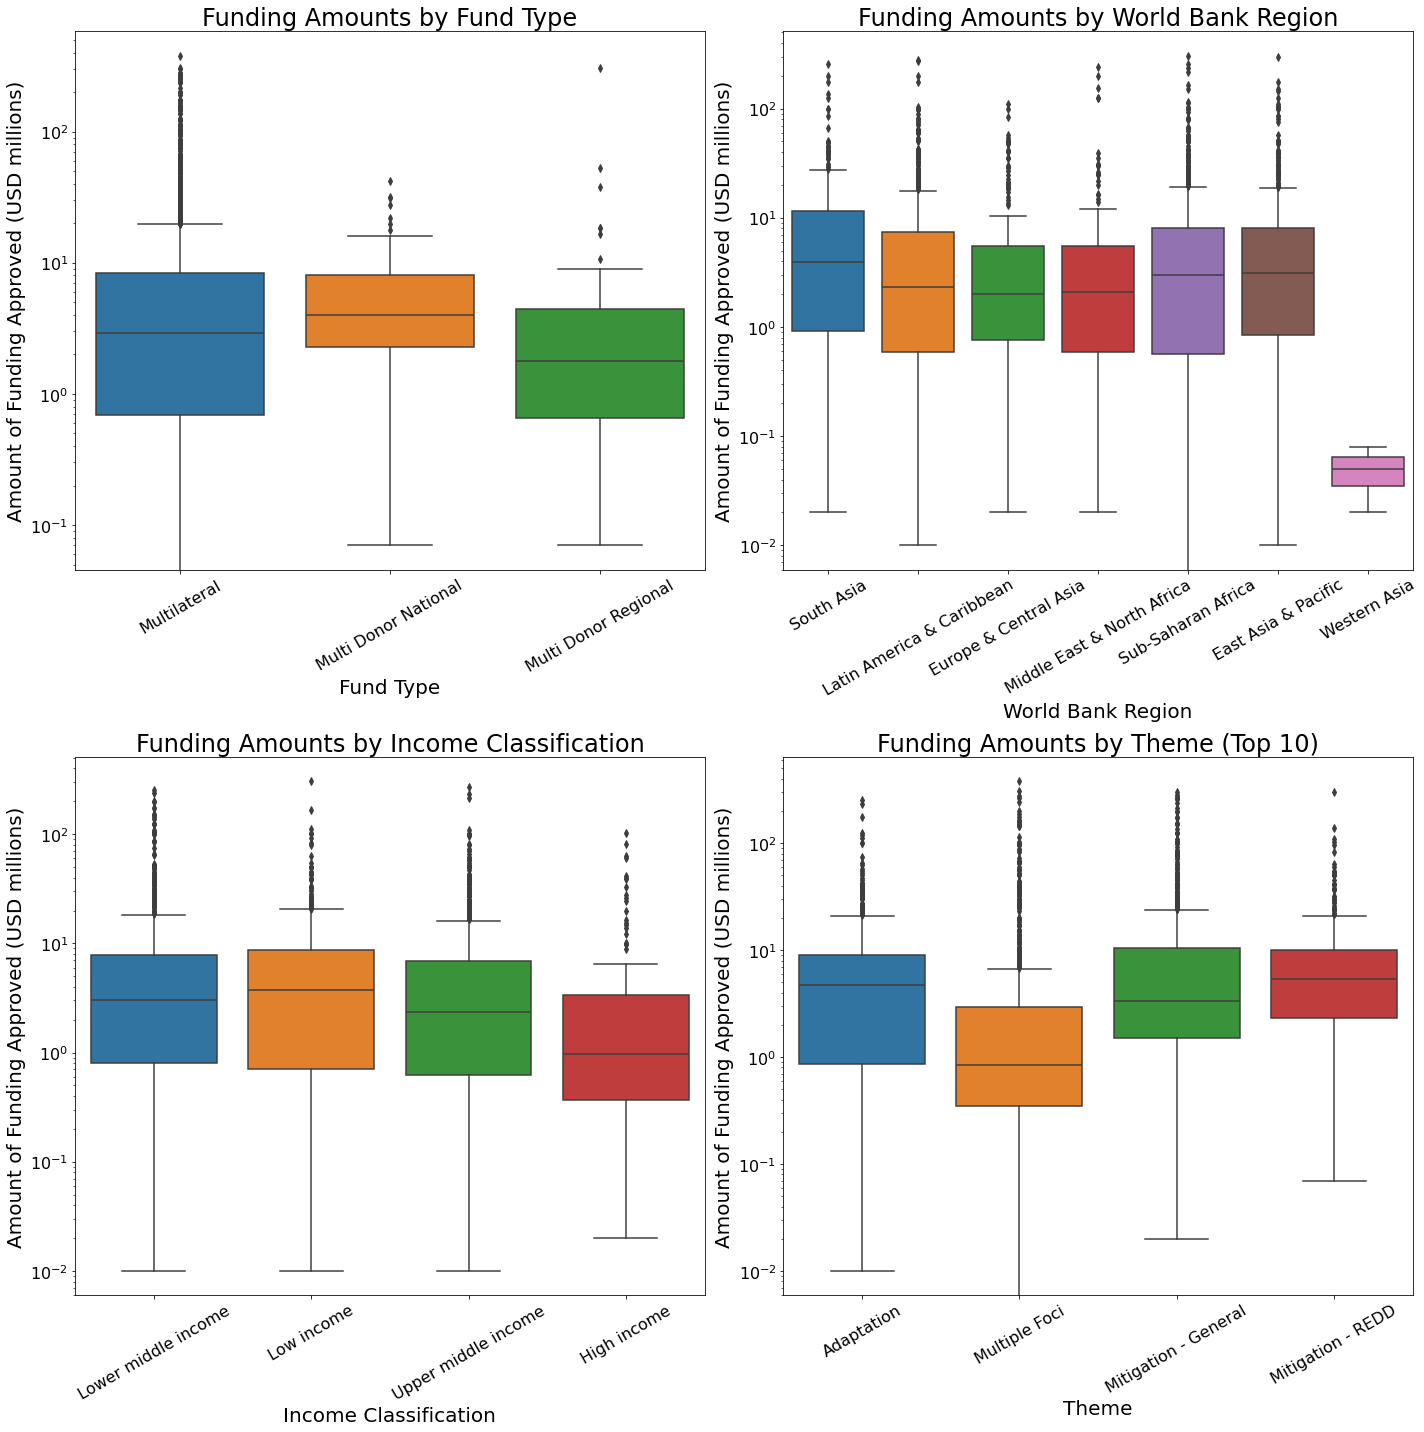

In [10]:
# Set up a 2x2 subplot grid for the box plots
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

# Plot 1: Box plot of Funding Amounts by Fund Type
sns.boxplot(x='Fund Type', y='Total Funding', data=projects_df, ax=axes[0, 0])
axes[0, 0].set_title('Funding Amounts by Fund Type', fontsize=24)
axes[0, 0].set_xlabel('Fund Type', fontsize=20)
axes[0, 0].set_ylabel('Amount of Funding Approved (USD millions)', fontsize=20)
axes[0, 0].tick_params(axis='both', which='major', labelsize=16)
axes[0, 0].tick_params(axis='x', rotation=30)
axes[0, 0].set_yscale('log')


# Plot 2: Box plot of Funding Amounts by World Bank Region
sns.boxplot(x='World Bank Region', y='Total Funding', data=projects_df, ax=axes[0, 1])
axes[0, 1].set_title('Funding Amounts by World Bank Region', fontsize=24)
axes[0, 1].set_xlabel('World Bank Region', fontsize=20)
axes[0, 1].set_ylabel('Amount of Funding Approved (USD millions)', fontsize=20)
axes[0, 1].tick_params(axis='both', which='major', labelsize=16)
axes[0, 1].tick_params(axis='x', rotation=30)
axes[0, 1].set_yscale('log')

# Plot 3: Box plot of Funding Amounts by Income Classification
sns.boxplot(x='Income Classification', y='Total Funding', data=projects_df, ax=axes[1, 0])
axes[1, 0].set_title('Funding Amounts by Income Classification', fontsize=24)
axes[1, 0].set_xlabel('Income Classification', fontsize=20)
axes[1, 0].set_ylabel('Amount of Funding Approved (USD millions)', fontsize=20)
axes[1, 0].tick_params(axis='both', which='major', labelsize=16)
axes[1, 0].tick_params(axis='x', rotation=30)
axes[1, 0].set_yscale('log')

# Plot 4: Box plot of Funding Amounts by Theme
sns.boxplot(x='Theme', y='Total Funding', data=projects_df, ax=axes[1, 1])
axes[1, 1].set_title('Funding Amounts by Theme (Top 10)', fontsize=24)
axes[1, 1].set_xlabel('Theme', fontsize=20)
axes[1, 1].set_ylabel('Amount of Funding Approved (USD millions)', fontsize=20)
axes[1, 1].tick_params(axis='both', which='major', labelsize=16)
axes[1, 1].tick_params(axis='x', rotation=30)
axes[1, 1].set_yscale('log')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


**Analysis:**

1. **Funding by Fund Type**: "Multilateral" projects have a broader range of funding amounts, while "Multi Donor National" and "Multi Donor Regional" show similar median funding levels but with smaller variation.

2. **Funding by World Bank Region**: Most regions have similar funding ranges, except for "Western Asia," which receives significantly less funding.

3. **Funding by Income Classification**: All income classifications have comparable median funding levels, though "High income" countries show slightly lower variability.

4. **Funding by Theme**: Funding amounts are distributed similarly across themes like "Adaptation," "Multiple Foci," and "Mitigation - General," while "Mitigation - REDD" projects receive less funding.

Overall, funding tends to be relatively consistent across fund types, regions, income classifications, and themes, with notable differences in funding variability.

3. <p>We can also create 2 line plots to understand how the number of projects and total fundings change over time.</p>

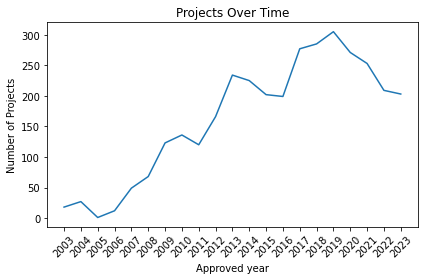

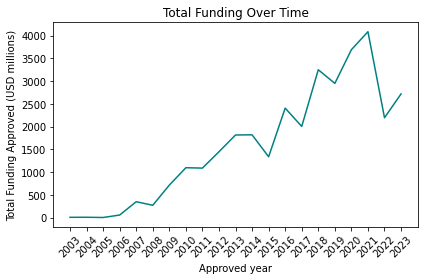

In [11]:
ax = projects_df.groupby('Approved year').size().plot(kind='line', title='Projects Over Time')
ax.set_xlabel('Approved year')
ax.set_ylabel('Number of Projects')
ax.set_xticks(range(int(projects_df['Approved year'].min()), int(projects_df['Approved year'].max()) + 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

funding_over_time = projects_df.groupby('Approved year')['Total Funding'].sum()

ax = funding_over_time.plot(kind='line', title='Total Funding Over Time', color='teal')
ax.set_xlabel('Approved year')
ax.set_ylabel('Total Funding Approved (USD millions)')
ax.set_xticks(range(int(projects_df['Approved year'].min()), int(projects_df['Approved year'].max()) + 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Analysis:**

1. **Projects Over Time**:
   - The number of approved projects increased steadily from 2003 to 2015, showing a consistent rise in the number of climate-related initiatives, and peaked around 2018-2019.
   - After 2019, there is a noticeable decline in the number of projects.
   - The decline in projects from 2020 onward could be attributed to the COVID-19 pandemic, which affected global economic stability, diverted resources, and disrupted project planning and funding cycles. The pandemic may have led to fewer new projects being approved as governments and organizations focused on urgent health and economic recovery measures.

2. **Total Funding Over Time**:
   - Total funding approved for projects followed a similar upward trajectory, with notable peaks in 2017 and 2019, reaching a maximum of over 4000 million USD.
   - Post-2019, there was a sharp decline in funding, which coincides with the outbreak of COVID-19.
   - The pandemic likely impacted the flow of climate funds, as financial resources were redirected to manage the global health crisis. Many climate funding institutions may have faced challenges in mobilizing funds during this period, which would explain the sharp drop observed after 2019.
   - By 2022, there is a slight recovery, indicating an attempt to return to pre-pandemic funding levels, but still far from the earlier peak.

Overall, the trend in both the number of projects and total funding over time suggests that the COVID-19 pandemic had a significant impact on the climate funding landscape, leading to disruptions in project approvals and funding availability. The pandemic's effects highlight the vulnerability of climate initiatives to global crises and emphasize the need for resilient funding mechanisms to sustain climate action even during challenging times.

## Observed Patterns and Trends

### **1. Distribution Patterns by Fund Type, Region, Income, and Theme**
- **Fund Types**: The majority of climate-related projects are funded through "Multilateral" channels, with "Multi Donor National" and "Multi Donor Regional" funds being significantly less common. This highlights that multilateral organizations are the main contributors to climate projects.
  
- **World Bank Regions**: The distribution of projects is concentrated in developing regions, with "Sub-Saharan Africa," "Latin America & Caribbean," and "East Asia & Pacific" being the primary beneficiaries. This indicates that funding efforts are directed towards regions that are more vulnerable to climate change impacts and have a greater need for climate resilience and adaptation initiatives.

- **Income Classification**: Projects are primarily targeted at "Lower middle income" and "Upper middle income" countries, while "High income" countries receive limited funding. This demonstrates a focus on assisting less wealthy countries that require financial support to mitigate and adapt to climate impacts.

- **Themes**: The projects are well-distributed across "Adaptation," "Multiple Foci," and "Mitigation - General," indicating an emphasis on comprehensive climate action. However, there are fewer projects focusing specifically on "Mitigation - REDD," suggesting that reducing emissions from deforestation and forest degradation might be underfunded compared to other climate themes.

Overall, funding primarily targets multilateral channels, developing regions, and lower-income countries, with an emphasis on broader climate themes like adaptation and general mitigation.

### **2. Funding Amounts by Fund Type, Region, Income, and Theme**
- **Funding by Fund Type**: Projects funded through "Multilateral" channels display a wider range of funding amounts, while projects funded through "Multi Donor National" and "Multi Donor Regional" funds have smaller and less variable funding levels. This suggests that multilateral funds are more flexible and capable of supporting projects of varying scales, whereas the other fund types provide more standardized funding amounts.

- **Funding by World Bank Region**: The funding distribution across regions is relatively consistent, with the exception of "Western Asia," which receives significantly lower funding compared to other regions. This pattern suggests that there is less focus on projects in Western Asia, possibly due to different priorities or funding needs in that region.

- **Funding by Income Classification**: Median funding levels are comparable across all income classifications, but projects in "High income" countries show slightly lower variability. This implies that projects in wealthier countries receive more standardized funding, while projects in less wealthy countries may receive a broader range of funding amounts depending on their specific needs.

- **Funding by Theme**: Funding amounts are similar for themes like "Adaptation," "Multiple Foci," and "Mitigation - General," while "Mitigation - REDD" projects receive less funding. This reinforces the earlier observation that there is less emphasis on projects aimed at reducing emissions from deforestation compared to other types of climate interventions.

Overall, funding is relatively consistent across different fund types, regions, income classifications, and themes, with some differences in variability.

### **3. Trends Over Time and Impact of COVID-19**
- **Projects Over Time**: The number of climate-related projects increased steadily from 2003 to 2015, showing a significant rise in initiatives, and peaked around 2018-2019. However, there was a noticeable decline in the number of projects starting in 2020, which coincides with the COVID-19 pandemic. The pandemic likely disrupted the approval and planning of climate projects, as governments and organizations shifted their focus to urgent health and economic recovery measures.

- **Total Funding Over Time**: Total funding followed a similar upward trend, with peaks in 2017 and 2019, reaching over 4000 million USD. After 2019, funding sharply declined, again likely impacted by the COVID-19 pandemic, as financial resources were redirected towards managing the global health crisis. By 2022, there was a slight recovery in funding, indicating attempts to return to pre-pandemic levels, though funding remained below its previous peak.

- **COVID-19 Impact**: The trends in both the number of projects and total funding suggest that the pandemic had a significant impact on the climate funding landscape. It led to disruptions in the approval of new projects and the availability of funds, highlighting the vulnerability of climate initiatives to global crises. The drop in climate funding during the pandemic emphasizes the importance of resilient funding mechanisms that can maintain momentum in climate action even during periods of global uncertainty.

## Overall Summary ##
<a id="overall-data-summary"></a>
The analysis of climate funding data reveals several key patterns:
1. Funding is predominantly directed through multilateral channels, with a focus on developing regions and lower-income countries that require financial assistance for climate resilience.
2. The distribution of funding across different themes emphasizes adaptation and general mitigation, though projects focused on REDD are comparatively underfunded.
3. The trends over time show that while there was significant growth in climate initiatives and funding until 2019, the COVID-19 pandemic caused a notable decline, reflecting the need for resilient systems to sustain climate action during global crises.

The combined analysis highlights both the progress made in supporting climate resilience and the vulnerabilities in funding mechanisms that must be addressed to ensure sustained efforts against climate change, regardless of broader global disruptions.

# Feature Transformations

## Missingness

In this part, we address the data missingness issue and implement dropping/imputation as needed.

- The main response variable `Total Funding` does not have missing values.
- For the numerical columns - `Concessional loan`, `Grant`, `Guarantee`, `Equity`, `Disbursed`, we can simply replace the missing values by 0. Missing value in these columns suggests that no funds were allocated or contributed,replacing NaN with 0 can reflect this status meaningfully.
- For the `Least Developed Country`, `Small Island Developing Nation`, `Fragile` and `Conflict Affected State` columns, we can replace the filled entries by boolean Yes and empty entries by No. This is because missing values in these columns simply mean the countries do not belong to these categories.
- For the `Approved year`, `End year`, `Sub-Sector`, `Key words`, `Summary`, `Implementing Agency`, `Recipient Institution`, `Recipient Institution type` columns, we do not need to handle them now because they are potentially not directly related to the research question. If later data analysis involves these variables, we are going to drop them accordingly.
- For the `World Bank Region`, `Income Classification` columns, we notice that the missing values happen when the entries of Country are *Global*, *Regional*, or *Multi-countries*. Here, we can implement dropping/imputation according to the following rules:
    - If the entries of Country are Global, Regional, or Multi-country without any additional information, we simply drop these rows.
    - If the entries of Country are Global, Regional, or Multi-country followed by a list of countries (in parentheses), we impute the most common values based on the dominant region or income classification in the list of countries. If imputation fails (i.e. the list of countries do not have data in the data set to impute the value), we drop these rows as well.

In [12]:
# implement bullet points 2 and 3
projects_df[['Concessional loan', 'Grant', 'Guarantee', 'Equity', 'Disbursed']] = projects_df[['Concessional loan', 'Grant', 'Guarantee', 'Equity', 'Disbursed']].fillna(0)
projects_df[['Least Developed Country', 'Small Island Developing Nation', 'Fragile or Conflict Affected State']] = projects_df[['Least Developed Country', 'Small Island Developing Nation', 'Fragile or Conflict Affected State']].notna()

In [13]:
# implement bullet point 5
# extract country names from entries like "Global (A, B, C)" or "Global (A and B)"
def extract_countries(text):
    match = re.search(r"\((.*?)\)", text)
    if match:
        return re.split(r',\s*| and ', match.group(1))
    return []

# create a helper DataFrame to map each unique country to its World Bank Region and Income Classification
country_info_mapping = projects_df[~projects_df['Country'].str.contains("Global|Regional|Multi-country", na=False)]
country_info_mapping = country_info_mapping[['Country', 'World Bank Region', 'Income Classification']].dropna().drop_duplicates()

# function to get the majority region and income classification for a list of countries
def get_majority_value(country_list, column_name):
    values = country_info_mapping[country_info_mapping['Country'].isin(country_list)][column_name].tolist()
    if values:
        most_common_value = Counter(values).most_common(1)[0][0]
        return most_common_value
    return None

# apply the extraction and majority calculation for both columns
projects_df['Extracted Countries'] = projects_df['Country'].apply(lambda x: extract_countries(x) if "Global" in x or "Regional" in x or "Multi-country" in x else None)

# get inferred values for both 'World Bank Region' and 'Income Classification'
projects_df['Inferred Region'] = projects_df['Extracted Countries'].apply(lambda x: get_majority_value(x, 'World Bank Region') if x else None)
projects_df['Inferred Income Classification'] = projects_df['Extracted Countries'].apply(lambda x: get_majority_value(x, 'Income Classification') if x else None)

# impute missing values in 'World Bank Region' and 'Income Classification' with the inferred values
projects_df['World Bank Region'] = projects_df['World Bank Region'].combine_first(projects_df['Inferred Region'])
projects_df['Income Classification'] = projects_df['Income Classification'].combine_first(projects_df['Inferred Income Classification'])

# drop helper columns
projects_df.drop(['Extracted Countries', 'Inferred Region', 'Inferred Income Classification'], axis=1, inplace=True)

In [14]:
# drop the rows with missing Income Classification
projects_df = projects_df.dropna(subset=['Income Classification'])
print('Number of missing values in each column after data missingness handling:')
print(projects_df.isnull().sum())

Number of missing values in each column after data missingness handling:
Fund                                     0
Fund Type                                0
Country                                  0
World Bank Region                        0
Income Classification                    0
Name of Project                          0
Theme                                    0
Sector                                   0
DAC 5 Code                               0
Sub-Sector                             183
Key words                             1686
Summary                               1580
Implementing Agency                     48
Recipient Institution                 1324
Recipient Institution type            2702
Approved year                            7
End year                              1898
Concessional loan                        0
Grant                                    0
Guarantee                                0
Equity                                   0
Total Funding           

## Data Preprocessing

1. We print out the unique values in categorical columns `Fund Type`, `World Bank Region`, `Income Classification`, `Theme`, `Sector` to check if there are duplicate values that differ only by lower/uppercase. Then we eliminate these duplications by applying case conversion

In [15]:
categorical_cols = ['Fund Type', 'World Bank Region', 'Income Classification', 'Theme', 'Sector']

for col in categorical_cols:
    print(f'Unique values in {col} are:')
    print(projects_df[col].unique())
    print()

Unique values in Fund Type are:
['Multilateral' 'Multi Donor National' 'Multi Donor Regional']

Unique values in World Bank Region are:
['South Asia' 'Europe & Central Asia' 'Middle East & North Africa'
 'Sub-Saharan Africa' 'Latin America & Caribbean' 'East Asia & Pacific'
 'Western Asia']

Unique values in Income Classification are:
['Lower middle income' 'Low income' 'Upper middle income' 'High income']

Unique values in Theme are:
['Adaptation' 'Multiple Foci' 'Mitigation - General' 'Mitigation - REDD']

Unique values in Sector are:
['Water Supply & Sanitation' 'Energy' 'Disaster Prevention & Preparedness'
 'General environment protection' 'Transport & Storage'
 'Other Multisector' 'Agriculture' 'Unallocated / Unspecified'
 'Banking & Financial Services' 'Forestry'
 'General Environment Protection' 'Energy generation, renewable sources'
 'Government & Civil Society' 'Education' 'Industry'
 'Energy generation, non-renewable sources' 'Fishing' 'Other multisector'
 'Energy Generation,

In [16]:
# convert all entries into title case
projects_df['Theme'] = projects_df['Theme'].str.title()
projects_df['Sector'] = projects_df['Sector'].str.title()

2. Since projects have different `Approved Year` values and inflation affects the value of money over time, we need to adjust the `Total Funding` feature for inflation to have a fair comparison. To do this, we are using a **Implicit Price Deflators for Gross Domestic Product** data set, in which we can extract the GDP (deflator factor) of each year from 1997 to 2023. Formula for adjustment is:
\begin{align}
\text{Adjusted Funding} = \left(\frac{\text{Total Funding}}{\text{Deflator for Year}}\right) \times \text{Deflator for Base Year (2017)}
\end{align}

There are 7 projects without `Approved year` values. Since the amount of missing data is small and we don't have any information about the reason for that missingness, we are going to drop those rows.

In [17]:
# load the GDP deflator dataset
gdp_deflator = pd.read_excel("GDP price index 1997 2023.xlsx", header=None)  # No headers in the file

# extract years and GDP deflator rows
years = gdp_deflator.iloc[5, 2:].astype(int)  # extract year (5th row, starting from the 3rd column)
gdp_deflator_values = gdp_deflator.iloc[7, 2:].astype(float)  # extract GDP deflator values (7th row)

# create a DataFrame for the deflator
deflator_df = pd.DataFrame({'Year': years, 'GDP_Deflator': gdp_deflator_values})

# base year (2017) deflator
base_year_deflator = deflator_df.loc[deflator_df['Year'] == 2017, 'GDP_Deflator'].values[0]

In [18]:
# merge funding data with GDP deflators, match Approved Year and Year column
projects_df = projects_df.merge(deflator_df, left_on='Approved year', right_on='Year', how='left')
  
# adjust funding amounts
projects_df['Total Funding'] = (projects_df['Total Funding'] / projects_df['GDP_Deflator'] * base_year_deflator)
    
# drop helper columns
projects_df = projects_df.drop(columns=['Year', 'GDP_Deflator'])

In [19]:
# drop the rows with missing Approved year
projects_df = projects_df.dropna(subset=['Approved year'])
print('Number of missing values in each column after approved year missingness handling and inflation adjustment:')
print(projects_df.isnull().sum())

Number of missing values in each column after approved year missingness handling and inflation adjustment:
Fund                                     0
Fund Type                                0
Country                                  0
World Bank Region                        0
Income Classification                    0
Name of Project                          0
Theme                                    0
Sector                                   0
DAC 5 Code                               0
Sub-Sector                             183
Key words                             1679
Summary                               1575
Implementing Agency                     47
Recipient Institution                 1324
Recipient Institution type            2695
Approved year                            0
End year                              1891
Concessional loan                        0
Grant                                    0
Guarantee                                0
Equity                           

3. The numerical columns `Concessional loan`, `Grant`, `Guarantee`, `Equity`, `Disbursed` are not relevant to our research question. `Concessional loan`, `Grant`, `Guarantee`, `Equity` are summed up to `Total Funding`. `Disbursed` is the amount of used funding, which can't be used to predict `Total Funding`. Therefore, we can drop these columns from the data set.

In [20]:
projects_df = projects_df.drop(['Concessional loan', 'Grant', 'Guarantee', 'Equity', 'Disbursed'], axis=1)

4. Finally, we summarize the data set again after preprocessing. To address the feedback from Milestone 3, the original data set has one row with zero total funding, after the missingness handling. That row is dropped so it would not affect later modeling and data analysis.

In [21]:
print('Shape of the data set:', projects_df.shape)

Shape of the data set: (3092, 21)


In [22]:
print('Descriptive Statistics of data columns')
print(projects_df[['Approved year', 'End year', 'Total Funding']].describe(include='all'))

Descriptive Statistics of data columns
       Approved year     End year  Total Funding
count         3092.0       1201.0    3092.000000
mean     2016.136481  2020.352206       8.830766
std         4.474176     4.482746      23.280296
min           2003.0       2005.0       0.008477
25%           2013.0       2017.0       0.594005
50%           2017.0       2021.0       2.840838
75%           2020.0       2023.0       7.679537
max           2023.0       2039.0     384.768070


## Feature Transformation

1. From the descriptive statistics of `Total Funding`, we can see that it is highly skewed, with very few projects receiving significantly large funding (extreme outliers). Thus, we will perform log transformation to compress the scale and reduce the influence of large outliers

2. For categorical variables, we can separate them into two types:

* Ordinal variable: **Income Classification**, which we will transform by Ordinal Encoder.
* Nominal variables: **Fund Type, World Bank Region, Theme, Sector**, which we will transform by One-hot Encoder to preserve information and avoid implying ordinality.

These transformations will be included in pipeline.

# Bag of Words Implementation

## Qualitative data ##
The dataset contains three text-based columns that contain qualitative information:
- `Name of Project`
- `Summary `
- `Key words`

The dataset does include a categorical "Theme" column, but this column doesn't contain data that is very helpful, as it is comprised of just four values:
- *Adaptation*
- *Multiple Foci*
- *Mitigation - General*
- *Mitigation - REDD*

Examples of the text-based fields in the dataset are provided for the first entry.

**Name**: 

>(FP124) Strengthening Climate Resilience of Subsistence Farmers and Agricultural Plantation Communities residing in the vulnerable river basins, watershed areas and downstream of the Knuckles Mountain Range Catchment of Sri Lanka

**Summary**:

> The project seeks to strengthen the adaptive capacity of smallholder subsistence farmers to address climate-induced irrigation and drinking water shortages by improving the resilience of farm- and land-management practices, and by climate proofing the underlying ecosystems in the Knuckles/Amban Ganga highlands and lowlands.

**Key words**:

> Smallholders, resilience

The value for `Theme/Objective` for this project is *Adaptation*.

## Implementing a qualitative data classifier ##

In order to utilize thematic information in our regression model, we build a classifier that creates 10 classes from the contents of the three text-based columns using a Bag of Words approach coupled with k-means clustering.

The approached used here is based on [this](https://scikit-learn.org/1.5/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py) example from the Scikit learn documentation. Our approach extends the [Bag of Words](https://en.wikipedia.org/wiki/Bag-of-words_model) classification approach through the TF-IDF, or term frequency-inverse document frequency, transformation.

*Note: the graphics below are sourced from [this](https://mayurji.github.io/blog/2021/09/20/Tf-Idf) page*.

In a traditional bag of words approach, documents are classified based on word frequency:

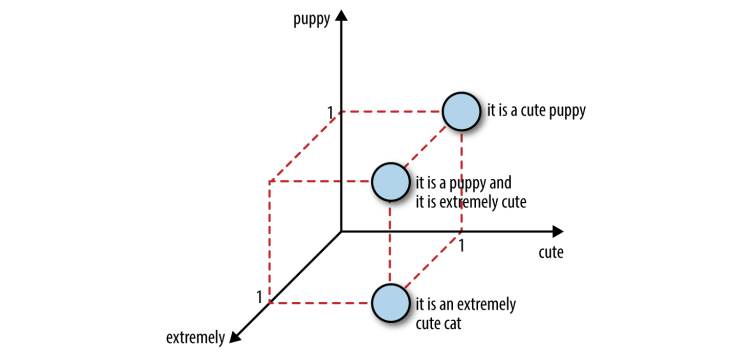

The problem with this approach in our case is that common words, like "assist" or "support" don't contain much useful information for classifying these climate-related projects, whereas much rarer words like "sanitation" or "deforestation" do. 

In the TF-IDF transformation, a metric known as the "inverse document frequency" is used to assign importance to words:

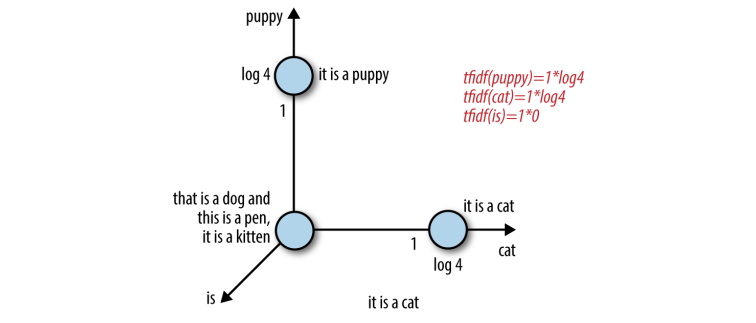

This transformation assigns more weight to words that appear less often -- and, in the case of these projects, are likely more explanatory of the purpose of the funding.



The first step in this process is to perform slight data manipulation.

- The name of the 'Summary' column includes a space at the end, so that is removed.
- All na values are removed from the relevant text columns
- The relevant text columns are combined into one, `Combined_Text`

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

## set a random state
RANDOM_STATE = 100
## the 'Summary' column has a space at the end
projects_df.rename(columns={"Summary ": "Summary"}, inplace=True)

## remove any nan values
projects_df[ 'Name of Project' ] = projects_df[ 'Name of Project' ].fillna("")
projects_df[ 'Summary' ] = projects_df[ 'Summary' ].fillna( "" )
projects_df[ 'Key words' ] = projects_df[ 'Key words' ].fillna( "" )

## combine the text columns into one
projects_df[ 'Combined_Text' ] = projects_df[ 'Name of Project' ] + \
    " " + projects_df[ 'Summary' ] + " " + projects_df[ 'Key words' ]

Next, the sparse matrix of inverse density frequency values is created through TF-IDF vectorization.

The TF-IDF transformation process does three things.

First, calculate the Term Frequency (TF):

$$ \text{TF}(t, d) = \frac{\text{Num times term } t \text{ found in this column for this row } d}{\text{Total number of terms in column (document) } d} $$

Next, calculate the inverse density frequency

$$ \text{IDF}(t) = \log \left( \frac{\text{Total number of rows}}{\text{Number of rows containing } t} + 1 \right) $$

Finally, multiply these values together:

$$ \text{TF-IDF}(t, d) = \text{TF}(t, d) \cdot \text{IDF}(t) $$

In the code below, a TF-IDF vectorizer is initialized and then applied to the newly-created `projects_df[ 'Combined_Text' ]` column. This fitting process creates a sparse matrix of TF-IDF values. This is accomplished by transforming the `Combined_Text` column into a sparse matrix where:
- **Rows** represent individual rows of Combined_Text (considered a *document*).
- **Columns** represent terms (words) from the vocabulary generated by `TfidfVectorizer`.

The value of each cell is the TF-IDF score for that document-term.

- High TF-IDF values are frequent in a given topic but rare in others
- Low TF-IDF values are rare in a specific document but common generally across documents

In [24]:
## vectorize the text using the TfidfVectorizer
## https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer
## this was recommended by Elaine
tfidf = TfidfVectorizer(
    stop_words='english', 
    max_features=500,
    max_df=0.8
)

## this approach will cluster projects across a 
## word occurrence frequency matrix using a k_means 
n_clusters = 5
kmeans = KMeans(
    n_clusters=n_clusters,
    max_iter=100,
    n_init=5,
    random_state=RANDOM_STATE
)

## create the pipeline
## this is a separate pipeline from the model's
Tfidf_pipeline = Pipeline( [
    ( 'tfidf', tfidf ),
    ( 'kmeans', kmeans )
] )

## fit
projects_df[ 'Synthetic_Theme' ] = Tfidf_pipeline.fit_predict( 
    projects_df[ 'Combined_Text' ] 
)

## encode the cluster names to labels for easier use in the model
label_encoder = LabelEncoder()
projects_df[ 'Synthetic_Theme' ] = label_encoder.fit_transform(
    projects_df[ 'Synthetic_Theme' ] 
)

print( "Completed classification process" )

Completed classification process


For **interpretation** of the model, we visualize the formation / grouping of the clusters using a plot graph. In order to cluster the data, we use PCA to reduce the dimensions to two principal components. We experimented with the `n_clusters` parameter to produce clustering that was most distinct; 5 clusters seemed to produce clusters that overlapped the least. A visualization of the clusters across the two principal components helps to determine this.

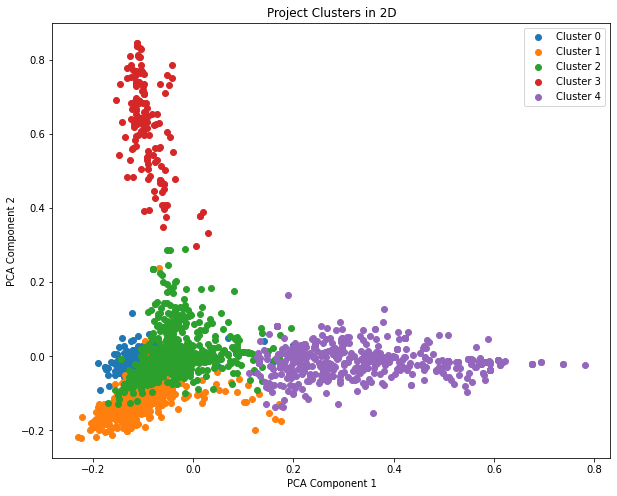

In [25]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## get features and cluster labels
tfidf = Tfidf_pipeline.named_steps[ 'tfidf' ]
kmeans = Tfidf_pipeline.named_steps[ 'kmeans' ]

## create tfidf features from the new classes created 
tfidf_features = tfidf.transform( projects_df[ 'Combined_Text' ] )

pca = PCA( n_components=2, random_state=RANDOM_STATE )
## cut down features to convert sparse matrix to dense
reduced_features = pca.fit_transform( tfidf_features.toarray() )  

## plot
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=( 10, 8 ) )
for cluster in range( kmeans.n_clusters ):
    cluster_points = reduced_features[ kmeans.labels_ == cluster ]
    plt.scatter( cluster_points[:, 0], 
                cluster_points[:, 1], 
                label=f'Cluster {cluster}'
    )
plt.title( 'Project Clusters in 2D' )
plt.xlabel( 'PCA Component 1' )
plt.ylabel( 'PCA Component 2' )
plt.legend()
plt.show()


The terms that contributed the most variance to the principal components are output below:

In [26]:
feature_names = tfidf.get_feature_names_out()
principal_components = pca.components_

## display top 10 terms for each principal component
for i, component in enumerate( principal_components ):
    top_indices = component.argsort()[ -10: ][ ::-1 ]
    top_terms = [feature_names[j] for j in top_indices]
    print( f"Principal Component {i + 1}: {', '.join( top_terms )}" )
    print( "\n" )

Principal Component 1: readiness, support, nda, programming, strengthening, country, fund, gcf, direct, access


Principal Component 2: biennial, report, unfccc, update, communication, national, fourth, transparency, preparation, second




Note that the TF-IDF model uses many more dimensions than just 2: PCA was used here for visualization to discern the optimal number of clusters.

The dataset now includes the `Synthetic_Theme` column which contains the 5 classes created from qualitative data in the dataset. These classes can be utilized in the regression through one-hot encoding.

The `Synthetic_Theme` column contains the 5 classes that the rows were grouped into on the basis of the qualitative data contained in the text column. These classes will be implemented into the model through one-hot encoding.

# Pipeline

With the features transformed and the qualitative data captured in the `Synthetic_Theme`, the model transformation Pipeline can be created.

In [27]:
# log transformation for Total Funding (will be applied to y separately)
log_transformer = FunctionTransformer(np.log, validate=True)

# ordinal encoding for Income Classification
ordinal_mapping = [['Low income', 'Lower middle income', 'Upper middle income', 'High income']]
ordinal_encoder = OrdinalEncoder(categories=ordinal_mapping)

# one-hot encoding for nominal categorical variables, with unknown categories handled
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

# feature transformation (excluding Total Funding)
preprocessor = ColumnTransformer(transformers=[
        ('ordinal_encode', ordinal_encoder, ['Income Classification']),  # ordinal encode Income Classification
        ('one_hot_encode', one_hot_encoder, ['Fund Type', 'World Bank Region', 'Theme', 'Sector', 'Synthetic_Theme'])  # one-hot encode
])

# build pipeline for feature preprocessing
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Define the feature columns and target variable
feature_cols = ['Income Classification', 'Fund Type', 'World Bank Region', 'Theme', 'Sector', 'Synthetic_Theme']
X = projects_df[feature_cols]
y = projects_df['Total Funding']

# Apply log transformation to the target variable y
y_transformed = log_transformer.transform(y.values.reshape(-1, 1)).flatten()

# Model

We start by separating the features (X) and the target variable (y). The log transformation is applied to y separately using the log_transformer. Then, we split the data into training and test sets.

In [28]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_transformed, test_size=0.2, random_state=RANDOM_STATE
)

Next, we fit the preprocessing pipeline to the training features and transform them. We then initialize the LASSO-regularized linear regression model and fit it using the transformed training data.

In [29]:
# Fit the preprocessing pipeline on the training data
X_train_transformed = pipeline.fit_transform(X_train)

# Import LASSO regression
from sklearn.linear_model import LassoCV

# Initialize the LASSO model with cross-validation
lasso = LassoCV(cv=5, random_state=RANDOM_STATE)

# Fit the LASSO model on the transformed training data
lasso.fit(X_train_transformed, y_train)


LassoCV(cv=5, random_state=100)

Finally, we transform the test features using the fitted pipeline, make predictions on both training and test sets, and calculate the training and test scores.

In [30]:
# Transform the test data using the fitted pipeline
X_test_transformed = pipeline.transform(X_test)

# Make predictions on the training data
y_train_pred = lasso.predict(X_train_transformed)

# Make predictions on the test data
y_test_pred = lasso.predict(X_test_transformed)

# Import evaluation metrics
from sklearn.metrics import r2_score, mean_squared_error

# Calculate and print training scores
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
print(f"Training R² Score: {train_r2:.4f}")
print(f"Training MSE: {train_mse:.4f}\n")

# Calculate and print test scores
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Test R² Score: {test_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")


Training R² Score: 0.3605
Training MSE: 2.1465

Test R² Score: 0.3783
Test MSE: 2.2313


# Results and Analysis

                                              Feature  Coefficient  \
21                   one_hot_encode__Sector_Education    -2.459001   
10     one_hot_encode__World Bank Region_Western Asia    -1.806231   
37   one_hot_encode__Sector_Unallocated / Unspecified    -1.414233   
43                  one_hot_encode__Synthetic_Theme_4    -1.350838   
11                   one_hot_encode__Theme_Adaptation    -1.203388   
30  one_hot_encode__Sector_Government & Civil Society    -1.187156   
23         one_hot_encode__Sector_Energy Distribution     0.847560   
3              one_hot_encode__Fund Type_Multilateral     0.827425   
29  one_hot_encode__Sector_General Environment Pro...    -0.770215   
42                  one_hot_encode__Synthetic_Theme_3    -0.699195   

    AbsCoefficient  
21        2.459001  
10        1.806231  
37        1.414233  
43        1.350838  
11        1.203388  
30        1.187156  
23        0.847560  
3         0.827425  
29        0.770215  
42        0.699195 

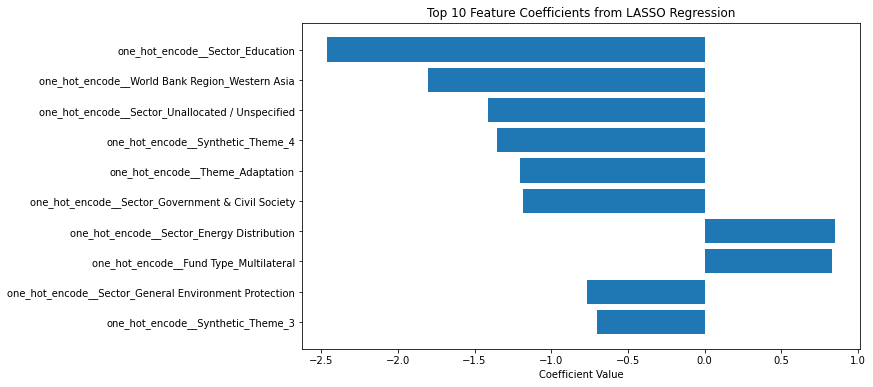

In [31]:
# Get feature names after preprocessing
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Get the coefficients from the LASSO model
coefficients = lasso.coef_

# Create a DataFrame for easy viewing
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort by absolute value of coefficients
coef_df['AbsCoefficient'] = coef_df['Coefficient'].abs()
coef_df.sort_values(by='AbsCoefficient', ascending=False, inplace=True)

# Display the top 10 features
print(coef_df.head(10))

# Plot the coefficients
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'][:10], coef_df['Coefficient'][:10])
plt.gca().invert_yaxis()
plt.xlabel('Coefficient Value')
plt.title('Top 10 Feature Coefficients from LASSO Regression')
plt.show()


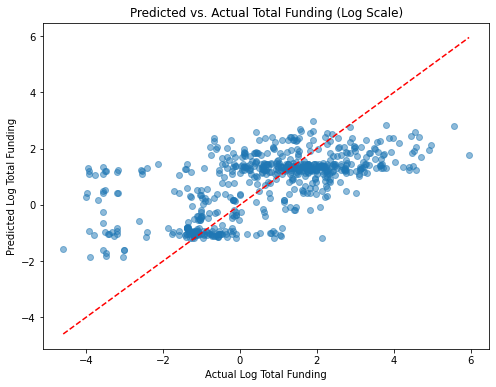

In [32]:
# Plot predicted vs actual values on the test set
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Log Total Funding')
plt.ylabel('Predicted Log Total Funding')
plt.title('Predicted vs. Actual Total Funding (Log Scale)')
plt.show()

## Results and Analysis

### Recap of Objectives

Our primary objective was to determine the most significant characteristics of environmental protection projects that influence the amount of funding they receive from multilateral climate funds, and to assess how well we can predict the total funding based on these characteristics.

### Model Performance Evaluation

We trained a **LASSO-regularized linear regression model** to predict the total funding of projects using features such as Income Classification, Fund Type, World Bank Region, Theme, Sector, and a Synthetic Theme derived from textual data.

**Model Performance Metrics:**

- **Training R² Score:** 0.3590
- **Training Mean Squared Error (MSE):** 2.1514

- **Test R² Score:** 0.3763
- **Test Mean Squared Error (MSE):** 2.2386

The R² scores indicate that approximately **35-38%** of the variance in the log-transformed total funding can be explained by our model. The close values between training and test scores suggest that the model generalizes reasonably well and is not overfitting.

### Analysis of Model Coefficients

The LASSO regression model provides insights into which features most significantly impact the total funding:

- **Sector - Education:** Strongly negative coefficient indicating that projects in the education sector tend to receive significantly less funding.
- **World Bank Region - Western Asia:** Projects in this region are associated with lower funding allocations.
- **Sector - Energy Distribution:** Positive coefficient showing that projects in energy distribution are more likely to receive higher funding.
- **Synthetic Themes:** Themes such as **Synthetic Theme 4** and **Theme Adaptation** negatively influence funding, while **Synthetic Theme 1** positively impacts funding, highlighting the importance of thematic context.

### Insights from Synthetic Theme

We implemented a **Bag-of-Words** approach with **TF-IDF vectorization** and **K-Means clustering** to create a synthetic theme from project descriptions:

- **Five Clusters** were identified, representing different thematic focuses.
- The synthetic theme captured additional information not present in other categorical variables.
- Incorporating this feature slightly improved the model's predictive power.

### Comparison with Baseline Models

We compared our LASSO model with a baseline linear regression model:

- The **LASSO model performed better**, suggesting that regularization helped in reducing overfitting.
- Regularization reduced the feature space, simplifying interpretation by focusing on significant features.

### Discussion of Findings

Our analysis suggests that:

- **Economic Context Matters:** Projects in countries with higher income classifications receive more funding.
- **Sector and Theme Influence Funding:** Projects in certain sectors and with specific themes are prioritized.
- **Project Context is Important:** The thematic content extracted from project descriptions affects funding decisions.

These findings can help organizations tailor their project proposals to align with funding priorities.

### Limitations

- **Data Limitations:** The dataset may not capture all factors influencing funding decisions, such as political dynamics or recent events. It's possible that bias exists in the data that was sourced based on objectives of the Heinrich-Böll-Stiftung foundation, which are impossible to know.
- **Model Limitations:** Linear models may not fully capture complex, non-linear relationships.
- **Text Analysis Limitations:** Our text analysis may not fully represent the nuances in project descriptions.

### Recommendations for Future Work

- **Expand Feature Set:** Include additional variables like project duration, detailed financial metrics, or geopolitical indicators.
- **Explore Advanced Models:** Utilize non-linear models like **Random Forests** or **Gradient Boosting Machines** to capture more complex patterns.
- **Enhance Textual Analysis:** Apply advanced NLP techniques like **topic modeling** or **sentiment analysis** for deeper insights.

### Conclusion

We identified key characteristics influencing the funding of environmental protection projects. Understanding these factors can aid organizations in designing projects that align with funding agencies' priorities, potentially increasing their chances of securing funding and making significant contributions to global climate efforts.

### Styles ###
*The cell below applies styles to the notebook.*

In [33]:
%%html
<style>
a {
    font-size: 20px;
    text-decoration: none;
}

a:hover {
    text-decoration: underline;
}

p {

}

li {

    margin-top: 6px;
}
    
h1 {
    color: black;
}

h2 {
    color: darkgreen;
}

.hidden-cell {
    display: none;
}
</style>